# Giant number fluctuations experiment notebook in DF project

## General guidelines
- This notebook is for experimenting the giant number fluctuations figures for DF project.
- Finalized figure should be implemented in the `Figure.ipynb` notebook.

## <font color='blue'> Plans

<font color='blue'>
    
- rewrite the document for `collapse_data`, arrange the figures
</font>

## Table of contents

1. Concentration dependence
    - Helper functions
        - GNF data postprocessing: `postprocess_gnf()
        - Combine multiple data to one curve with errorbar: `collapse_data()`
        - Prepare multiple data: `prepare_multiple_data()`
        - Compare with predictions from theory and simulation: `plot_predictions()`
    - Plot using the functions we just defined
        - $\Delta N / \sqrt N$ vs. $l^2$ at various concentrations
        - $\alpha$ vs. concentration
    - Some thoughts on the fitting range of $\alpha$
2. GNF kinetics
    - Helper functions
        - $\Delta N / \sqrt N$ vs. $l^2$ at differnet times: `plot_std()`
        - $\alpha$ and image intensity vs. $t$: `plot_kinetics()`
        - Move light on time to 0: `kinetics_from_light_on()`
        - Plot energy, order and GNF together: `plot_kinetics_eo()`
        - Move light-on time to 0 for plot_kinetics_eo() data: `kinetics_eo_from_light_on()`
        - Smoothing the data: `kinetics_eo_smooth()`
    - Plot kinetics using the functions defined above

## Packages 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
import corrLib
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from scipy import signal
from scipy.interpolate import griddata
import matplotlib
import pandas as pd
from scipy.ndimage import gaussian_filter1d, uniform_filter1d
import typesetting.main as tm
from corr_utils import *
from IPython.display import clear_output

In [3]:
color_dict, marker_list = unified_symbols() # keep color and symbol consistent across different plot, for same concentrations
data_master_dir = r'E:\Google Drive' # data folder: Google drive for now, but may change in the future
tm.prl('1-column-2-panel') # control the default plotting configurations, now I realize the parameters should vary from plot to plot
dirs = data_log_mapping(kw='aug') # video info for GNF raw data, obtained from Aug 3rd to Aug 6th

## 1. Concentration dependence

### 1.1 Helper functions

#### 1.1.1 GNF data postprocessing
The GNF data generated by `df2_nobp.py` or `df2_kinetics.py` program is a DataFrame containing columns ('n', 'd'). 
    
    n -- boxsize in pixel square
    d -- standard deviation of total intensity (proportional to std of concentration, so the slope on log-log plot is the same as that of concentration)
    
When plotting, we don't directly plot $n$ and $d$. Instead, we make several changes:
- normalize x-axis (box size) with bacteria size $l_b^2$
- scale y-axis with box side length (proportional to the square root of average number of bacteria in each box $\sqrt N$)
- shift the curve in vertical direction, to make the first point start from 1
- (optional) set an x-limit, to exclude too large (>100) or too small (<1) box  size data
- (optional) make sparse the curve, in case the plot looks crowded

The function ```postprocess_gnf()``` below performs the changes described above. The return values of this function are ready to plot.

```Python
def postprocess_gnf(gnf_data, lb, xlim=None, sparse=3):
    """
    Postprocess raw GNF data for plotting.
    
    Args:
    gnf_data -- DataFrame containing columns ('n', 'd'), generated by df2_nobp.py
    lb -- size of bacteria (pixel, normalizing factor of x axis)
    xlim -- box size beyond which the data get cut off (pixel), can be either integer or a list of 2 integers
            if xlim is int, it is the upper limit, data above xlim will be cut off,
            if xlim is a list, data outside [xlim[0], xlim[1]] will be cut off
    sparse -- the degree to sparsify the data, 1 is doing nothing, 3 means only keep 1/3 of the orginal data
    
    Returns:
    x, y -- a tuple that can be plotted directly using plt.plot(x, y)
    """
    ...
    return x, y
```

**Change the axis limits:**

The GNF curves become smoother and have less kinks (almost none) after increasing the number of sampling regions. The left part of the plot shows clear slopes, while the right part plateaus. The variation of image intensity initially increases rapidly with box size when boxes are small. As boxes are getting too large, so that one box can contain a lot of variation inside itself, the increasing trend start to break down. In another words, if we increase the box size to the maximum, i.e. the whole image, the value of $\Delta N / \sqrt N$ would be very small. This explain why some curves show a decreasing trend at large $l^2/l_b^2$ regime. 

The large box size end data is not of interest in the scope of giant number fluctuations. Therefore, we choose a cutoff box size, only below which we show the image intensity variation as a function of box size. 

$$ \left(\frac{l}{l_b}\right) < 10 $$

This is a reasonable choice because the correlation length analysis shows that the intensity correlation length is around 15 um, corresponding to $ (l/l_b)_{cut} = 5 $. Here we show a slightly larger range than the correlation length, which does not change the fluctuation magnitude observed. 

To the lower limit, we set 

$$ \left(\frac{l}{l_b}\right) \ge 3 $$

Imagine if $ \left(\frac{l}{l_b}\right) < 3 $, then the box we examine is too small to have enough bacteria for statistical purposes. In such box, concentration fluctuations are ill defined, and would not reflect the real number fluctuation.

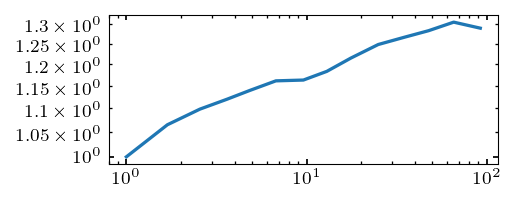

In [3]:
# test postprocess_gnf()
a = pd.read_csv(r'E:\moreData\03032020\df2_nobp\10n0\16-bit\df_average.csv')
x, y = postprocess_gnf(a, 10, xlim=[1, 100], sparse=3)
plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')

#### 1.1.2 Combine multiple data to one curve with errorbar

For each concentration, I have several replicates. It would be nice to have all of them contribute to the final plot, but plotting them all out would be too crowded:
<img src='https://github.com/ZLoverty/Personal-Images/blob/master/07142020/GNF-crowded.png?raw=true' width=50%>

Instead of the crowded plot above, I want to collapse curves with the same concentration into one curve, like below:
<img src='https://github.com/ZLoverty/Personal-Images/blob/master/07142020/GNF-clean.png?raw=true' width=50%>

In addition, I want to add **errorbars** to represent variations between samples. Thus, I design function ```collapse_data()``` as follows:
```Python
def collapse_data(gnf_data_tuple, lb, xlim=None, sparse=3):
    """
    Args:
    gnf_data_tuple -- a tuple of gnf_data (dataframe) generated by df2_nobp.py, it has to be a tuple
    lb -- size of bacteria (pixel, normalizing factor of x axis)
    xlim -- box size beyond which the data get cut off (pixel), can be either integer or a list of 2 integers
            if xlim is int, it is the upper limit, data above xlim will be cut off,
            if xlim is a list, data outside [xlim[0], xlim[1]] will be cut off
    sparse -- the degree to sparsify the data, 1 is doing nothing, 3 means only keep 1/3 of the orginal data
    
    Returns:
    collapsed -- DataFrame containing ('x', 'avg', 'std')    
        'x' -- l**2/lb**2 used for plotting GNF, index
        'avg' -- average values of given dataset (gnf_data_tuple)
        'err' -- standard deviation of given dataset
    """
    ...
    return collapsed
```

           avg       std
x                       
0.01  1.000000  0.000000
0.02 -0.322352  0.172096
0.03  0.025847  0.965141
0.04  0.434913  0.805795
0.05 -0.567222  0.588930


<ErrorbarContainer object of 3 artists>

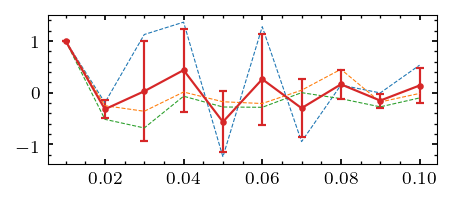

In [2]:
# test collapse_data()
x = range(1, 11)
d1 = pd.DataFrame(data={'n': x, 'd': np.random.randn(10)*100})#.set_index('n')
d2 = pd.DataFrame(data={'n': x, 'd': np.random.randn(10)*100})#.set_index('n')
d3 = pd.DataFrame(data={'n': x, 'd': np.random.randn(10)*100})#.set_index('n')

lb = 10
xlim = 100
sparse = 1
collapsed = collapse_data((d1, d2, d3), lb, xlim=xlim, sparse=sparse)
print(collapsed.head())
plt.plot(*postprocess_gnf(d1, lb, xlim=None, sparse=1), lw=0.5, ls='--')
plt.plot(*postprocess_gnf(d2, lb, xlim=None, sparse=1), lw=0.5, ls='--')
plt.plot(*postprocess_gnf(d3, lb, xlim=None, sparse=1), lw=0.5, ls='--')
plt.errorbar(collapsed.index, collapsed.avg, yerr=collapsed['std'], marker='o', capsize=2, lw=1, markersize=2)

#### 1.1.3 Prepare multiple data

Before plotting the data, we note that the function ```collapse data()``` requires the data of same concentration be grouped in a tuple. Thus, a helper function ```prepare_multiple_data()``` is needed that converts a list of data directories into a tuple. 
```Python
def prepare_multiple_data(dirs):
    """
    Args:
    dirs -- a list of directories of GNF data
    
    Returns:
    gnf_data_tuple -- a tuple of GNF DataFrame ('n', 'd')
    """
    ...
    return gnf_data_tuple
```
<font color='red'><b>Comment to myself: </b></font>This function is not very useful at the moment. In the future, the code will look at the log file and find all the experiment that matches the conditions. At that time, I will need to use list to contain all the directories to I can append items when going through the log.

In [3]:
# test prepare_multiple_data(dirs)
dirs = [r'E:\moreData\02042020\df2_nobp\20-1\df_average.csv', r'E:\moreData\02042020\df2_nobp\20-2\df_average.csv', r'E:\moreData\02042020\df2_nobp\20-3\df_average.csv']
gnf_data_tuple = prepare_multiple_data(dirs)
print('Length of gnf_data_tuple: ' + str(len(gnf_data_tuple)))

Length of gnf_data_tuple: 3


#### 1.1.4 Compare with predictions from theory and simulation

- Toner and Tu PRL, 1995: $\Delta N \propto N^{0.5+z/d}$, 2D: 0.3; 3D: 0.27
- Ramaswamy EPL, 2003: $\Delta N \propto N^{0.5+1/d}$, 2D: 0.5; 3D: 0.33
- Mahault PRL, 2019: 2D: 0.33; 3D: 0.3

| Author | Journal | Year | 2D | 3D |
|-------|----|----|---|---|
| Toner and Tu | PRL | 1995 | 0.3 | 0.27 |
| Ramaswamy  | EPL | 2003 | 0.5 | 0.33 |
| Mahault | PRL | 2019 | 0.33 | 0.3 |

```Python
def plot_predictions(ax, key='M19'):
    """
    Plot predictions from theory and simulations along with my data in ax. 
    2D predictions will be '--', 3D predictions will be '.-'. 
    
    Args:
    ax -- axis where I plot my data
    key -- the prediction to plot, can be 'TT95', 'R03' or 'M19', default to 'M19'
    Returns:
    None    
    """
    ...
    return None
```

Text(0, 0.5, '$\\alpha$')

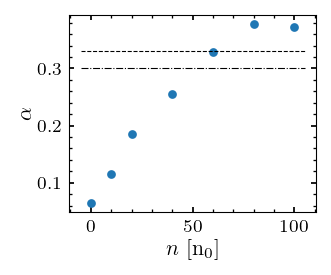

In [15]:
# test plot_predictions()
concs = [0, 10, 20, 40, 60, 80, 100]
slopes = [0.041, 0.095, 0.205, 0.258, 0.339, 0.389, 0.392]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(concs, slopes, ls='', marker='o', color=bestcolor(0),
        markersize=3)
plot_predictions(ax)
ax.set_xlabel('$n$ [n$_0$]')
ax.set_ylabel('$\\alpha$')

### 1.2 Plot using the functions we just defined

Now let's start to plot GNF data using the functions we just defined:
```
postprocess_gnf(gnf_data, lb, xlim=None, sparse=3)
collapse_data(gnf_data_tuple, lb, xlim=None, sparse=3)
prepare_multiple_data(dirs)
```
- For concentrations with only one set of data, use ```postprocess_gnf()``` to get x, y and plot the raw data
- For concentrations with more than one sets of data, use ```prepare_multiple_data()``` and ```collapse_data()``` to plot average with errorbars in y

#### 1.2.1 Plot $\Delta N$ at various concentrations

In [2]:
# generate directory data dirs
dirs = {}
dirs['0'] = [r'E:\moreData\02182020\df2_nobp\static\df_average.csv']
dirs['10'] = [r'E:\moreData\03032020\df2_nobp\10n0\16-bit\df_average.csv']
dirs['20'] = [r'E:\moreData\02042020\df2_nobp\20-1\df_average.csv', 
              r'E:\moreData\02042020\df2_nobp\20-2\df_average.csv', 
              r'E:\moreData\02042020\df2_nobp\20-3\df_average.csv',
              r'E:\moreData\Dynamics_raw\df2_nobp\20\df_average.csv']
dirs['40'] = [r'E:\moreData\02042020\df2_nobp\40-1\df_average.csv', 
              r'E:\moreData\02042020\df2_nobp\40-2\df_average.csv', 
              r'E:\moreData\02042020\df2_nobp\40-3\df_average.csv']
dirs['60'] = [r'E:\moreData\02042020\df2_nobp\60-1\df_average.csv', 
              r'E:\moreData\02042020\df2_nobp\60-2\df_average.csv', 
              r'E:\moreData\02042020\df2_nobp\60-3\df_average.csv',
             r'E:\moreData\Dynamics_raw\df2_nobp\60\df_average.csv']
dirs['80'] = [r'E:\moreData\02042020\df2_nobp\80-1\df_average.csv', 
              r'E:\moreData\02042020\df2_nobp\80-2\df_average.csv', 
              r'E:\moreData\02042020\df2_nobp\80-3\df_average.csv',
             r'E:\moreData\Dynamics_raw\df2_nobp\80\df_average.csv']
dirs['100'] = [r'E:\moreData\Dynamics_raw\df2_nobp\100\df_average.csv']

Text(4.8, 3.3630204922657763, '0.5')

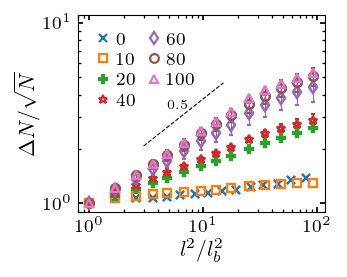

In [3]:
# plot std as a function of box size for various concentrations of bacteria
count = 0
symbol_list = [ 'x', 's', 'P', '*', 'd', 'o', '^']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for kw in dirs:    
    gnf_data_tuple = prepare_multiple_data(dirs[kw])
    collapsed = collapse_data(gnf_data_tuple, 10, xlim=[1, 100], sparse=3)
    ax.plot(collapsed.index, collapsed.avg, mec=bestcolor(count), 
            label=kw, lw=0, marker=symbol_list[count], markersize=4, mfc=(0,0,0,0), mew=1)
    ax.errorbar(collapsed.index, collapsed.avg, yerr=collapsed['std'], 
                 marker=symbol_list[count], capsize=1, lw=0, elinewidth=0.5, mec=bestcolor(count), 
                markersize=4, mfc=(0,0,0,0), mew=1, ecolor=bestcolor(count))
    count += 1
ax.loglog()
ax.set_ylim([0.9, 11])
# ax.yaxis.set_major_formatter(ScalarFormatter())

ax.legend(ncol=2)
ax.set_xlabel('$l^2/l_b^2$')
ax.set_ylabel('$\Delta N/\sqrt{N}$')

# guide of the eye slope
x = np.array([3, 15])
y = x**0.5 *1.2
ax.plot(x, y, color='black', lw=0.5, ls='--')
ax.text(0.6*x[0]+0.2*x[1], 0.5*y[0]+0.5*y[1], '0.5', fontsize=6)
# plt.savefig(r'E:\Github\Personal-Images\07142020\GNF-clean.png', fmt='png')

#### 1.2.2  Plot slope $\alpha$ as a funciton of concentration

Now let's extract the slope from the curves above. I will do the calculation above again, without plotting the results out. 

**Note** that instead of fitting the original data with $y=ax^b$, I am going to take a log both axes and fit a straight line $y=ax+b$. This  remedy the extreme value effect from large values. 

Text(0, 0.5, '$\\alpha$')

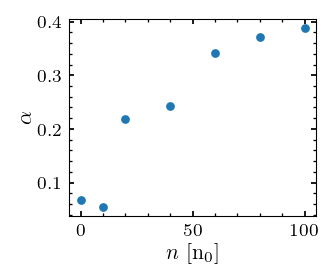

In [8]:
# here we use the directory data again, so run the cell of dirs before running this cell
concs = []
slopes = []
std = []

for kw in dirs:    
    gnf_data_tuple = prepare_multiple_data(dirs[kw])
    collapsed = collapse_data(gnf_data_tuple, 10, xlim=[1, 100], sparse=3) # xlim controls the fitting range
    x = np.log(collapsed.index)
    y = np.log(collapsed.avg)
    p = np.polyfit(x, y, deg=1)
    concs.append(int(kw))
    slopes.append(p[0])
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(concs, slopes, ls='', marker='o', color=bestcolor(0),
        markersize=3)
ax.set_xlabel('$n$ [n$_0$]')
ax.set_ylabel('$\\alpha$')

### 1.3 Some thoughts on the fitting range of $\alpha$

The so called "Giant number fluctuations", or more specifically, its strength $\alpha$'s I extracted from images, can vary upon the range of curve fitting. Up to today, Sept 15th, the $\alpha$'s have been obtained by fitting $\Delta N/\sqrt N$ - $l^2/l_b^2$ curve in the range \[1, 100\] of $l^2/l_b^2$, i.e. all the fittings are done within a length scale between 1 and 10 bacterial body length. Though this range turns out to work great for high concentration samples, where 30 um is always about twice of the concentration correlation length, or the same at the velocity correlation length. In such a range, the variance of concentration increases with observation window size at a mostly constant rate, so a robust fitting can be expected. However, for low concentration samples, both correlation lengths are significantly smaller, so that 30 um - 10 bacterial body length - is no longer twice of the concentration correlation length, or the same at the velocity correlation length. In such a range, concentration variance plateaus already, likely, so that the curve fitting does not reflect the slope of the constant rate increasing regime, but rather a combination of an increasing regime and a plateau regime. This ill-defined range of fitting leads to strange behavior of $\alpha$. 

Here, I will first plot $\Delta N/\sqrt N$ - $l^2/l_b^2$ for all concentrations. Since the data are from kinetics data, where multiple segments present, here we only use the last segment. In the future, for better statistics, we can average over the last few segments. Then, I will rescale the x-axis with both concentration correlation length and velocity correlation length. It will be shown, that the increase of variance plateaus around these length scales. Lastly, I will fit the $\Delta N/\sqrt N$ - $l^2/l_b^2$ again, in the range between 1 and that corresponding to velocity correlation length. And then plot the new $\alpha$-$n$ relation.

In [7]:
log = data_log_mapping(kw='aug')
date = []
num = []
conc = []
for kw in log:
    if int(kw) <= 120:
        conc.append(int(kw))
        d, n = log[kw][0].split('-')
        date.append(d)
        num.append(int(n))
data_log = pd.DataFrame().assign(conc=conc, date=date, num=num).sort_values(by='conc')

In [3]:
data_log

,conc,date,num
11,0,08032020,12
10,10,08042020,9
9,20,08032020,9
8,30,08042020,6
7,40,08032020,6
6,50,08042020,3
5,60,08032020,3
4,70,08042020,0
3,80,08032020,0
2,85,08052020,3


Text(0, 0.5, ' $\\Delta N/\\sqrt N$')

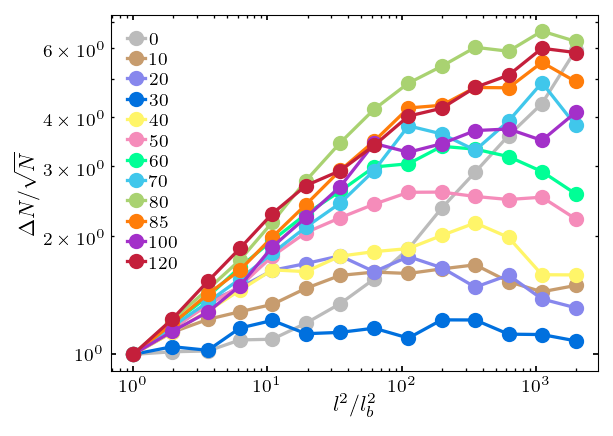

In [8]:
fig, ax = plt.subplots(figsize=(4, 3))
lb = 10

data_dir = r'D:\density_fluctuations\{0}\df2_kinetics\{1:02d}\kinetics_data.csv'
for num, i in data_log.iterrows():
    k_data = pd.read_csv(data_dir.format(i.date, i.num))
    gnf_data = k_data.loc[k_data.segment==k_data.segment.max()]
    x, y = postprocess_gnf(gnf_data, lb, xlim=[1, 10000], sparse=3)
    ax.plot(x, y, marker='o', label=str(i.conc), color=wowcolor(num))
ax.loglog()
ax.legend(loc='upper left')
ax.set_xlabel('$l^2/l_b^2$')
ax.set_ylabel(' $\Delta N/\sqrt N$')

In the plot above, towards the right, all the curves show a trend of slowing down of the rate of increase (except 0, for the fluctuations of illumination dominates). This slowing-down happens at different length scales. For 80 n0 curve, it happens around 100. The same scale applies to 50, 60, 70 n0, (and 40 n0 more or less), the collective motion concentrations. It seems that the range \[1, 100\] is a good choice of fitting range. And indeed, in the old data, all curve fittings were done in this range, as indicated by the gray dashed line in the picture below. 

<img src='temp_data\gnf_raw.JPG' width='500' >

However, we notice that for low concentration the range \[1, 100\] no longer reflects the initial constant increasing, but rather a combination of increase and plateau. Thus, the slope obtained from fitting such a range results in meaningless values. In the picture, I point out the slowing-down point for low concentration curves. They are around 2 to 3 times of bacterial body size, indicating a very weak correlation at these concentrations. Fitting such curves in range \[1, 100\] will for sure give very small slopes, of which the meanings are unclear.

This ill-defined fitting is best illustrated by the concentration 0. The increase was initially very small, which is consistent with intuition. When watch window gets sufficiently large, the slope ramps up to almost 0.5, the maximum possible value. This strange behavior is a result of the natural fluctuations of the illumination light source. Within a small range, the spatial variation of image can compete with light fluctuations. When watch window gets larger, since this is blank sample, no significant spatial variation can be introduced, so that it can no longer catch up with the overall temporal variation imposed by light. As a result, the variation shoots up. 

In addition, I want to explain more on why illumination light fluctuations can produce such large slope when watch window is large. The intuition is that, when I examine local concentrations of particles in a sample, some of them increase while others decrease. This is true, as long as the sample conserves number of particles. The so called giant number fluctuations, describe a scenario, where I look at the concentration at one point and it increases, then if I sample more area around this point, I will find the increase is still there, as if I was still looking at the point. In a randomly fluctuating system, when sampling larger and larger area, the fluctuation of one point would be averaged out by the fluctuations at other points, so that the fluctuations in a big area will eventually be negligible, compared to the size of the whole system. Now imagine, in an set of images, dominated by a spatially homogeneous, but temporally fluctuating light source, when sampling bigger and bigger area, the variance of the total pixel intensity, will always increase with the area linearly, because each single pixel exhibits exactly the same fluctuations. That is to say, $\Delta N \sim \langle N \rangle$. 

So the fluctuations of light source always exists, why in high concentration samples it does not give rise to this strange behavior of the curves? This has to be understood by realizing that it's the ratio between the fluctuations of the light source (spatially uniform, temporal fluctuating) and the intrinsic temporal fluctuations together, which determines the fluctuations of the whole system. The picture below shows how external overall fluctuations and intrinsic fluctuations together influence the number fluctuations strength $\alpha$. When noise (the intrinsic fluctuations) dominates, $\alpha$ (coded by color) is small (original image is generated by uniformly distributed random numbers). When light (external overall fluctuations) dominates, $\alpha$ tends to 0.5.

<img src='temp_data\light_noise.JPG' width='500'>

Now we realize that, low concentration samples have different length scales where a curve fitting is still meaningful. I believe the length would be either the concentration correlation length, or the velocity correlation length. Next, we will rescale the x-axis of the plot above by both quantities.

Text(0, 0.5, ' $\\Delta N/\\sqrt N$')

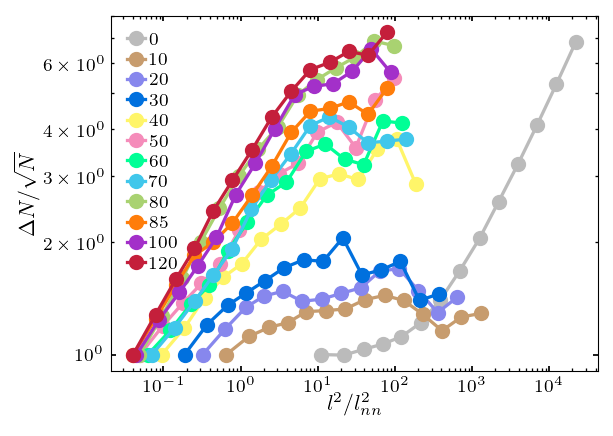

In [163]:
fig, ax = plt.subplots(figsize=(4, 3))
lb = 10

corrI = pd.read_excel(io=r'I:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='corrI')
data_dir = r'D:\density_fluctuations\{0}\df2_kinetics\{1:02d}\kinetics_data.csv'
for num, i in data_log.iterrows():
    k_data = pd.read_csv(data_dir.format(i.date, i.num))
    gnf_data = k_data.loc[k_data.segment==k_data.segment.max()]
    x, y = postprocess_gnf(gnf_data, lb, xlim=[1, 10000], sparse=3)
    ax.plot(x/corrI.loc[corrI.conc==i.conc].avg.values[0]**2*lb**2, y, marker='o', label=str(i.conc), color=wowcolor(num))
ax.loglog()
ax.legend(loc='upper left')
ax.set_xlabel('$l^2/l_{nn}^2$')
ax.set_ylabel(' $\Delta N/\sqrt N$')

Text(0, 0.5, ' $\\Delta N/\\sqrt N$')

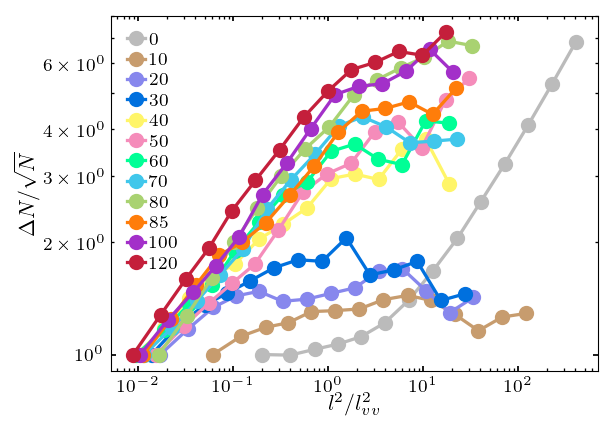

In [165]:
fig, ax = plt.subplots(figsize=(4, 3))
lb = 10

corrV = pd.read_excel(io=r'I:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='corrV')
data_dir = r'D:\density_fluctuations\{0}\df2_kinetics\{1:02d}\kinetics_data.csv'
for num, i in data_log.iterrows():
    k_data = pd.read_csv(data_dir.format(i.date, i.num))
    gnf_data = k_data.loc[k_data.segment==k_data.segment.max()]
    x, y = postprocess_gnf(gnf_data, lb, xlim=[1, 10000], sparse=3)
    ax.plot(x/corrV.loc[corrV.conc==i.conc].avg.values[0]**2*lb**2, y, marker='o', label=str(i.conc), color=wowcolor(num))
ax.loglog()
ax.legend(loc='upper left')
ax.set_xlabel('$l^2/l_{vv}^2$')
ax.set_ylabel(' $\Delta N/\sqrt N$')

From the rescaling above, I found that velocity correlation length is the best natural length scale for the fitting. Nonetheless, it still does not do the job perfectly. Thus, I will just use the range \[1, 10\] for $l^2/l_b^2$ since it works best for low concentrations, while high concentration data are mostly robust throughout the whole range. 

Next, I will plot $\alpha$ as a function of concentration with the new fitting.

Text(0, 0.5, '$\\alpha$')

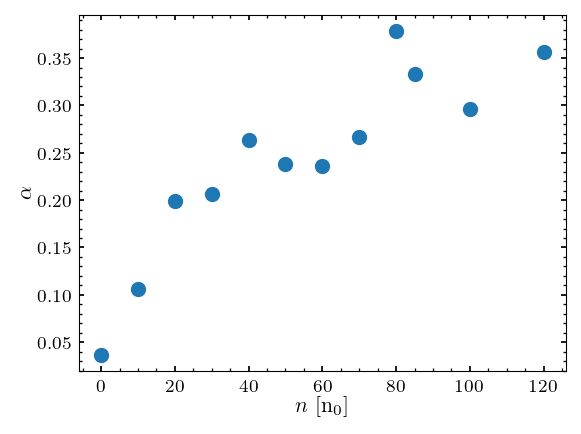

In [181]:
fig, ax = plt.subplots(figsize=(4, 3))
lb = 10

data_dir = r'D:\density_fluctuations\{0}\df2_kinetics\{1:02d}\kinetics_data.csv'
alpha = []
for num, i in data_log.iterrows():
    k_data = pd.read_csv(data_dir.format(i.date, i.num))
    gnf_data = k_data.loc[k_data.segment==k_data.segment.max()]
    x, y = postprocess_gnf(gnf_data, lb, xlim=[1, 10], sparse=3)
#     ax.plot(x, y, marker='o', label=str(i.conc), color=wowcolor(num))
    p = np.polyfit(np.log(x), np.log(y), deg=1)
    alpha.append(p[0])
plt.plot(data_log.conc, alpha, marker='o', ls='')
# ax.legend(loc='upper left')
ax.set_xlabel('$n$ [n$_0$]')
ax.set_ylabel('$\\alpha$')

## 2 GNF Kinetics

### 2.1 Helper functions
#### 2.1.1 Plot $\Delta N$ as a function of box size at different time

We start off by plotting $\Delta N/\sqrt{N}$ as a function of $l^2/l_b^2$ at different time, like below.
```Python
def plot_std(k_data, seg_length, tlim=None, xlim=None, lb=10, mpp=0.33, fps=10, num_curves=5):
    """
    Args:
    k_data -- kinetics data computed by df2_kinetics.py, has 3 columns (n, d, segment)
    seg_length -- segment length [frame] used in computing kinetics
    tlim -- bounds of time, only plot the data in the bounds (second)
            tlim can be None, int or list of 2 int
                None - plot all t
                int - plot all below tlim
                list - plot between tlim[0] and tlim[1]
    xlim -- box size beyond which the data get cut off (pixel), can be either integer or a list of 2 integers
    lb -- size of single bacterium [px]
    mpp -- microns per pixel
    fps -- frames per second
    num_curve -- number of curves in the final plot
    
    Returns:
    plot_data -- a dict containing (x, y)'s of all the curved plotted
                example {'l1': (x1, y1), 'l2': (x2, y2)} 
                where x1, y1, x2, y2 are all array-like object
    fig -- the figure handle of the plot, use for saving the figure
    ax -- axis of the plot
    """
    ...
    return return plot_data, fig, ax
```

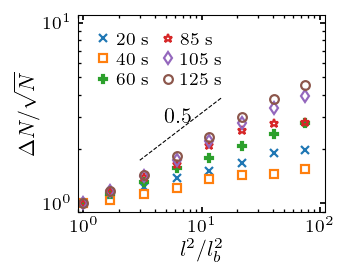

In [2]:
# test plot_std(k_data, seg_length, tlim=None, xlim=None, lb=10, mpp=0.33, fps=10, num_curves=5)
seg_length = 50
k_data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics_norm\01\kinetics_data.csv'.format(seg_length))
plot_data, fig, ax = plot_std(k_data, seg_length, tlim=[20, 150], xlim=[1, 100], lb=10, mpp=0.33, fps=10, num_curves=6)
# guide of the eye slope
x = np.array([3, 15])
y = x**0.5 * 1
ax.plot(x, y, lw=0.5, ls='--', color='black')
ax.text(0.6*x[0]+0.2*x[1], y.mean(), '0.5')
ax.axis([0.9, 110, 0.9, 11])
ax.legend(ncol=2)

#### 2.1.2 Plot $\alpha$ together with light intensity


We can clearly see the effect of light (or velocity) on the giant number fluctuations.
```Python
def plot_kinetics(k_data, i_data, tlim=None, xlim=None, lb=10, mpp=0.33, seg_length=100, fps=10):
    """
    Plot evolution of number fluctuation exponents and light intensity on a same yyplot
    refer to https://matplotlib.org/gallery/api/two_scales.html
    
    Args:
    k_data -- kinetics data computed by df2_kinetics.py
    i_data -- light intensity evolution extracted by overall_intensity.py
    lb -- size of bacteria (pixel, normalizing factor of x axis)
    mpp -- microns per pixel
    seg_length -- segment length when computing kinetics [frame]
    fps -- frames per second
    
    Returns:
    fig -- figure object
    ax1 -- the axis of kinetics
    """
    ...
    return fig, ax1
```

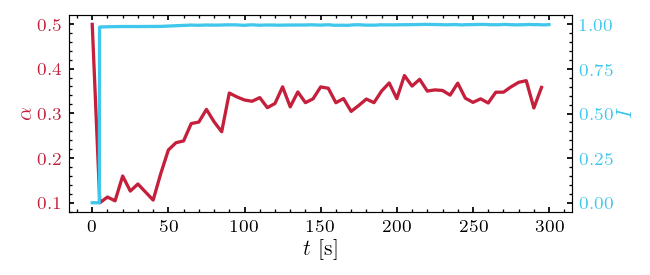

In [2]:
# test plot_kinetics(k_data, i_data, tlim=None, xlim=None, lb=10, mpp=0.33, seg_length=100, fps=10)
tm.prl('1-column-1-panel')
num = 1
seg_length = 50
k_data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics_norm\01\kinetics_data.csv'.format(seg_length, num))
i_data = pd.read_csv(r'E:\moreData\06232020\overall_intensity\{0:02d}\intensity.csv'.format(num))
data, fig, ax1 = plot_kinetics(k_data, i_data, tlim=[0, 300], xlim=[1, 100], lb=10, mpp=0.33, seg_length=seg_length, fps=10)

#### 2.1.3 Move light-on time to 0

In the previous function, light is turned on at 4.8 s instead of 0. As a result, the light intensity curve shows a sudden jump at 4.8 s. A worse thing about the graph is that, the first point of GNF curve has a very high value, due to the sudden change of light intensity in the first computation bracket. Therefore, I design function ```kinetic_from_light_on()``` to replot the data.

In this function, we only plot $\alpha$ as a function of $t$ and do not plot light intensity again since it's always constant and starts from time 0.
```Python
def kinetics_from_light_on(data):
    """
    Args:
    data -- dict of ('t0', 'alpha', 't1', 'i'), return value of plot_kinetics()
    
    Returns:
    new_data -- dict of ('t0', 'alpha', 't1', 'i'), where 't0' and 't1' are translated according to the light on time, so that light is on at time 0.
    """
    ...
    return new_data, fig, ax1
```

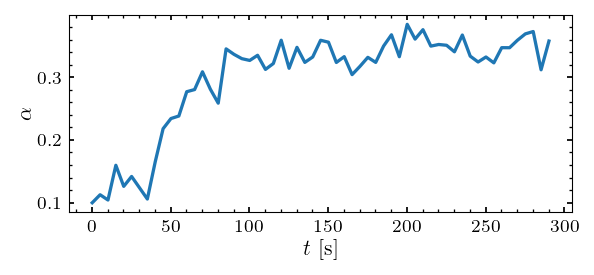

In [5]:
# test kinetic_from_light_on(data)
new_data, fig, ax = kinetics_from_light_on(data)

#### 2.1.4 Plot energy, order and GNF together

**Plot raw data**

This plot allows us to see how GNF evolves with flow energy and flow order, which further provides us insight into the mechanism of giant number fluctuations.
```Python
def plot_kinetics_eo(k_data, i_data, eo_data, tlim=None, xlim=None, lb=10, mpp=0.33, seg_length=100, fps=10):
    """
    Plot evolution of number fluctuation exponents and light intensity on a same yyplot
    In addition, plot flow energy and flow order in the same figure as well
    
    Args:
    k_data -- kinetics data computed by df2_kinetics.py
    i_data -- light intensity evolution extracted by overall_intensity.py
    eo_data -- energy and order data (t, E, OP), t has unit second, computed by energy_order.py
    tlim -- time range in which data is plotted
    xlim -- range for fitting the gnf curve
    lb -- size of bacteria (pixel, normalizing factor of x axis)
    mpp -- microns per pixel
    seg_length -- segment length when computing kinetics [frame]
    fps -- frames per second
    
    Returns:
    fig -- figure object
    ax1 -- the axis of kinetics
    """
    ...
    return data, fig, ax
```

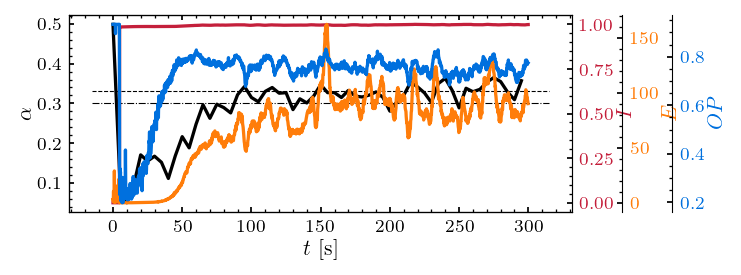

In [3]:
# test plot_kinetics_eo(k_data, i_data, eo_data, tlim=None, xlim=None, lb=10, mpp=0.33, seg_length=100, fps=10)
eo = pd.read_csv(r'E:\moreData\06232020\energy_order\01\energy_order.csv')
k = pd.read_csv(r'E:\moreData\06232020\df2_kinetics_norm\01\kinetics_data.csv')
i = pd.read_csv(r'E:\moreData\06232020\overall_intensity\01\intensity.csv')
data, fig, ax1 = plot_kinetics_eo(k, i, eo, tlim=300, xlim=[1, 10], lb=10, mpp=0.33, seg_length=50, fps=10)
plot_predictions(ax1[0])

#### 2.1.5 Move light-on time to 0 for plot_kinetics_eo() data

In this function, we only plot $\alpha$, $E$ and $OP$ as a function of $t$ and do not plot light intensity again since it's always constant and starts from time 0.
```Python
def kinetics_eo_from_light_on(data):
    """
    Args:
    data -- dict of (t0, alpha, t1, i, t2, E, OP), return value of plot_kinetics_eo()
    
    Returns:
    new_data -- dict of (t0, alpha, t1, i, t2, E, OP), modified so that light-on time is 0
    """
    ...
    return new_data, fig, ax
```

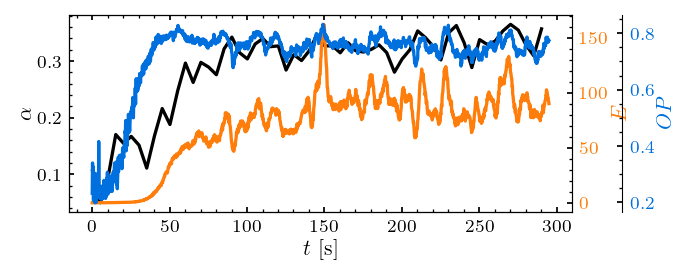

In [4]:
# test kinetics_eo_from_light_on(data)
new_data, fig, ax = kinetics_eo_from_light_on(data)

#### 2.1.6 Smoothing the data

Although the trend in GNF data is pretty obvious, we want to make it smoother by applying an average filter to the data.
```Python
def kinetics_eo_smooth(data):
    """
    Generate smoothed data and plot them.
    
    Args:
    data -- dict of (t0, alpha, t1, i, t2, E, OP), return value of kinetics_eo_from_light_on(data) or plot_kinetics()
    
    Returns:
    new_data -- smoothed data, dict of (t0, alpha, t1, i, t2, E, OP)
    
    Note:
    Although there are many ways to smooth the curve, I apply here a gaussian filter with sigma=1/15*total_data_length to do the work.
    Also try uniform filter with same 'size'   
    """
    ...
    return new_data, fig, ax
```

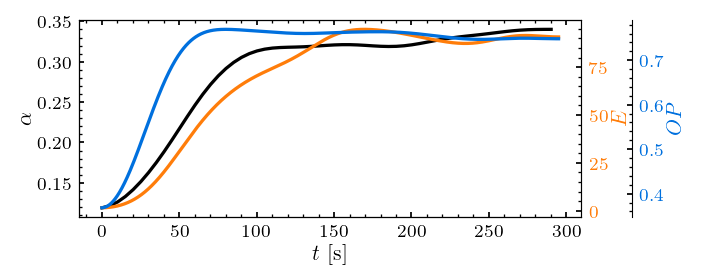

In [5]:
# test kinetics_eo_smooth(data)
nn_data, fig, ax = kinetics_eo_smooth(new_data)

### 2.2 Plot kinetics using the function defined above

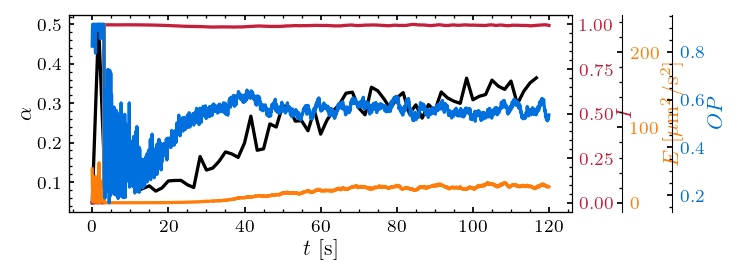

In [15]:
eo = pd.read_csv(r'E:\moreData\08032020\energy_order\02\energy_order.csv')
k = pd.read_csv(r'E:\moreData\08032020\df2_kinetics\02\kinetics_data.csv')
i = pd.read_csv(r'E:\moreData\08032020\overall_intensity\02\intensity.csv')
data, fig, ax = plot_kinetics_eo(k, i, eo, tlim=300, xlim=[0, 120], lb=10, mpp=0.33, seg_length=50, fps=30)

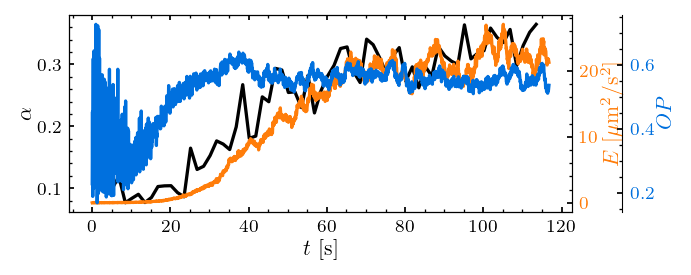

In [16]:
new_data, fig, ax = kinetics_eo_from_light_on(data)

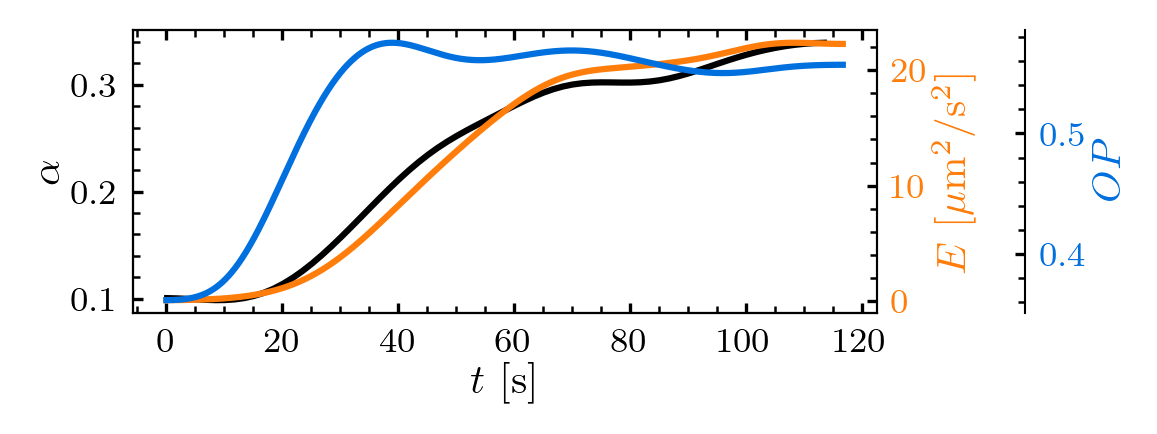

In [17]:
smooth_data, fig, ax = kinetics_eo_smooth(new_data)
ax.set_xlim([-5, 122])

## 3. Explore different ways to normalize GNF curves

### 3.1 The equivalence between $\Delta N/\sqrt N$ and $\Delta I / l$

In the GNF curves above, when plotting $\Delta N/\sqrt N$, the actual data being plotted are $\Delta I / l$, where $I$ is the total pixel intensity in a subsystem and $l$ is the side length of the subsystem. We believe these two quantities are just different by a scaling factor, which does not affect the scaling exponent $\alpha$, so we initially just force the first points of the curves corresponding to different concentrations to be the same, by rescaling the curves with the $y$ value of the first points. 

The basis of this assumption is the following:

- the linear relation between total pixel intensity $I$ and particle volume fraction $\phi$ entails that the variation of $
\Delta I$ is proportional to the variation of total particle number $\Delta N$, given that the total volume is fixed, which is always true in our experiment. The linear relation can be written in the following form
$$
\Delta I = a(n, I_0) \Delta N
$$
where $a(n, I_0)$ is the proportional factor, which is a function of number concentration $n$, and original illumination light intensity $I_0$. To understand the determining factors of $a$, let's first consider imaging a dense and a dilute bacterial suspensions using the same illumination light. As shown in Fig.1 in the paper, the dense suspension results in a image much darker than the dilute one, so that the intensity variation $\Delta I_{dense}$ cannot be larger than the brighter image of the dilute suspension $\Delta I_{dilute}$. However, we know that a denser suspension almost always show larger number fluctuations,  $\Delta N_{dense}>\Delta N_{dilute}$. As a result,
$$
a_{dense} = \frac{\Delta I_{dense}}{\Delta N_{dense}} < \frac{\Delta I_{dilute}}{\Delta N_{dilute}} = a_{dilute}
$$
This example shows the density dependence of the scaling factor $a$. Now let's turn to the illumination condition $I_0$ dependence. Consider the scenario where we image the same bacterial suspension with two different illumination intensity $I_low$ and $I_high$. A higher intensity does not scale up every pixel intensity proportionally. As a result, the difference between the lowest intensity and highest intensity gets larger, so does the temporal variation. For the same number fluctuations $\Delta N$, higher illumination intenstiy $I_{high}$ results in a higher intensity fluctuation $\Delta I_{high}$, which is higher than the low intensity counterpart $\Delta I_{low}$. Thus,
$$
a_{high} = \frac{\Delta I_{high}}{\Delta N} > \frac{\Delta I_{low}}{\Delta N} = a_{low}
$$
Although $a$ is highly dependent on experimental conditions, within in each measurement, where both $n$ and $I_0$ are constant through out the whole run, $a$ can be considered as a constant and we can write $\Delta I = a \Delta N$ for each experiment.

- The number of particles in a subsystem $N$ can be calculated by
$$
N = nl^2d
$$
where $d$ is the sample thickness. Again, it's dependent on the number density $n$ and will vary upon experimental conditions. However, within each experiment, $n$ is constant.

- We combine the two key relations above to get
$$
\frac{\Delta I}{l} = a\sqrt{nd}\frac{\Delta N}{\sqrt N}
$$
where we see, in a specific experimental condition, $\frac{\Delta I}{l}$ and $\frac{\Delta N}{\sqrt N}$ are only different by a constant $a\sqrt{nd}$, which does not affect the scaling exponent $\alpha$.

### 3.2 The need for normalization when comparing different concentrations

Although $\Delta I/l$ is satisfactory when we are interested only in extracting $\alpha$, it is not sufficient when we want to compare $\Delta N/\sqrt N$, the number fluctuations, at different concentrations. Since the scaling factor $a$ highly depends on the density $n$ and illumination intensity $I_0$, comparing the value of $\Delta I/l$ at different density is meaningless. For this reason, a normalization is needed so that we can rescale all the $\Delta I/l$ properly, for a meaningful comparison.

The small length limit $l \rightarrow l_b$, where $l_b$ is the single bacterium length, provides the common ground for different concentrations. Consider such a small subsystem that can only contain 1 particle to the maximum, the number fluctuations in that subsystem, $\Delta N$, can be obtained following the central limit theorem, since no particle-particle correlation should happen in this small box. Actually, such a "equilibrium" like behavior has been observed in quite a few experimental systems, where $\Delta N/\sqrt N$ is approximately a constant when only a few particles are present in the subsystem (see Narayan2007 and Zhang2010). A simple calculation can reveal the value of $\lim_{l \to l_b} \Delta N / \sqrt N$:

$$
\lim_{l \to l_b}\Delta N = \sqrt{\frac{1}{N} (N\phi(1-\phi)^2+N(1-\phi)(1-\phi)^2 } = \sqrt{\phi(1-\phi)}
$$

consider the mean number of particles in the subsystem $N = \phi$, we have
$$
\lim_{l \to l_b}\frac{\Delta N }{\sqrt N} = \sqrt{1-\phi}
$$

The value above should in principle hold true for bacterial suspensions at all volume fractions $\phi$ in our experiment. Therefore, it provides a means to rescale our $\Delta I / l$ data, and allows for meaningful comparisons over number fluctuations at different concentrations.

### 3.3 Redesign helper functions

Since we change the way of preparing GNF data, the corresponding function which is responsible for preparing ready-to-plot data needs to be modified. As far as I am concerned, the only function that needs to be changed is the `postprocess_gnf()`. To avoid issues, I want to keep the default behavior of the function, which rescale the starting point of all curves to 1. An additional keyword argument `normalize` will be added, and default to `'1'`, which standards for rescaling by the first point. Optionally, `normalize` can be set to `small-scale`, which applies the normalization described in Section 3.2. If `small-scale` is chosen, an additional keyword argument, `volume_fraction` will be required in order to calculate the rescaling factor. (implement after dinner)

In [29]:
def postprocess_gnf(gnf_data, lb, xlim=None, sparse=3, normalize='1', volume_fraction=None ,mpp=0.33):
    """
    Postprocess raw GNF data for plotting.
    
    Args:
    gnf_data -- DataFrame containing columns ('n', 'd'), generated by df2_nobp.py or df2_kinetics.py
    lb -- size of bacteria (pixel, normalizing factor of x axis)
    xlim -- box size beyond which the data get cut off (pixel), can be either integer or a list of 2 integers
            if xlim is int, it is the upper limit, data above xlim will be cut off,
            if xlim is a list, data outside [xlim[0], xlim[1]] will be cut off
    sparse -- the degree to sparsify the data, 1 is doing nothing, 3 means only keep 1/3 of the orginal data
    normalize -- the method to normalize the data. Choose from '1', None or 'small-scale'.
                 '1': rescale y with y[0]
                 'small-scale': rescale y with y[0] / \sqrt{1 - volume_fraction}. Additional volume_fraction arg is required.
                 None: no normalization will be applied.
    
    Returns:
    x, y -- a tuple that can be plotted directly using plt.plot(x, y)
    """    
    
    if xlim == None:
        data = gnf_data
    elif isinstance(xlim, int):
        data = gnf_data.loc[gnf_data.n < xlim*lb**2]
    elif isinstance(xlim, list) and len(xlim) == 2:
        data = gnf_data.loc[(gnf_data.n>=xlim[0]*lb**2)&(gnf_data.n < xlim[1]*lb**2)]  
    
    if normalize == '1':
        xx = data.n / lb**2
        yy = data.d / data.n**0.5
        yy = yy / yy.iat[0]
    elif normalize == None:
        xx = data.n / lb**2
        yy = data.d / data.n**0.5
    elif normalize == 'small-scale':
        assert(volume_fraction is not None)
        assert(volume_fraction < 1)
        assert(xlim[0] <= 1) # make sure the first data point is at a smaller scale than lb
        xx = data.n / lb**2
        yy = data.d / data.n**0.5
        yy = yy / yy.iat[0] * (1 - volume_fraction) ** 0.5        
    else:
        raise ValueError('Invalid normalize argument')
    
    # sparcify
    x = xx[0:len(xx):sparse]
    y = yy[0:len(xx):sparse]
    
    return x, y

Text(0, 0.5, '$\\Delta N/\\sqrt N$')

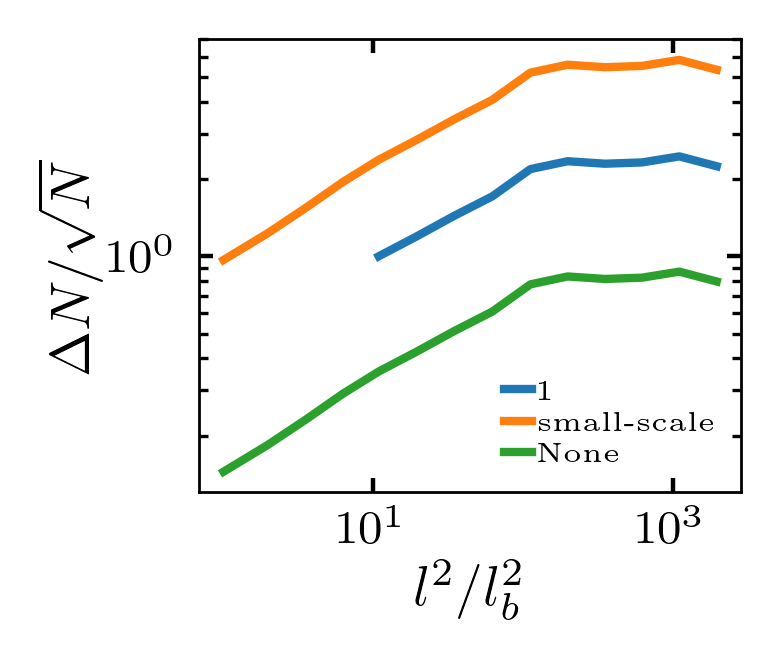

In [47]:
# test new postprocess_gnf(gnf_data, lb, xlim=None, sparse=3, normalize='1', volume_fraction=None ,mpp=0.33)
data = pd.read_csv(r'E:\moreData\08032020\df2_kinetics\01\kinetics_data.csv')
gnf_data = data.loc[data.segment==50]
lb = 10
# test normalize = '1'
x, y = postprocess_gnf(gnf_data, lb, xlim=[10, 10000], sparse=3, normalize='1')
plt.plot(x, y, label='1')
# test normalize = 'small-scale'
x, y = postprocess_gnf(gnf_data, lb, xlim=[1, 10000], sparse=3, normalize='small-scale', volume_fraction= 0.064)
plt.plot(x, y, label='small-scale')
# test normalize = '1'
x, y = postprocess_gnf(gnf_data, lb, xlim=[1, 10000], sparse=3, normalize=None)
plt.plot(x, y, label='None')
plt.loglog()
plt.legend(fontsize=5)
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/\sqrt N$')

## 4 Rearrange GNF data and plot

In order to directly compare GNF and energy spectra, we need to rearrange the data so that the two sets of data match each other on every length scale and at every time.

### 4.1 Rearrange normalized GNF data

The following block generates normalized GNF data and save them in folder "transient-nGNF-energy".

In [32]:
conc, folders, sample_num = tentative_log()
lb = 10
seg_length = 50
master_file = os.path.join(data_master_dir, r'Research projects\DF\data\level-2-data\{0}\df2_kinetics\{1:02d}\kinetics_data.csv')
out_folder = 'transient-nGNF-energy'
out_filename = 'nGNF_data.csv'
for c, f, s in zip(conc, folders, sample_num):
    for sn in s:
        file = master_file.format(f, sn)
        k_data = pd.read_csv(file)
        volume_fraction = c * 8e-4
        for num, seg in enumerate(k_data.segment.drop_duplicates()):
            subdata = k_data.loc[k_data.segment==seg]
            x, y = postprocess_gnf(subdata, lb, xlim=[1, 10000], sparse=1, normalize='small-scale', volume_fraction=volume_fraction)
            temp = pd.DataFrame(data={'l_r': x, str((seg-1)*seg_length): y}).set_index('l_r')
            if num == 0:
                master = temp
            else:
                master = pd.concat([master, temp], axis=1)
        dest_file = file.replace('level-2-data', out_folder).replace('kinetics_data.csv', out_filename)
        dest_folder = os.path.split(dest_file)[0]
        if os.path.exists(dest_folder) == False:
            os.makedirs(dest_folder)
        master.to_csv(dest_file)
        print("Write {0}-{1:02d}".format(f, sn))
clear_output(wait=True)        

Write 08062020-03
Write 08062020-04
Write 08062020-05
Write 08062020-00
Write 08062020-01
Write 08062020-02
Write 08052020-03
Write 08052020-04
Write 08052020-05
Write 08032020-00
Write 08032020-01
Write 08032020-02
Write 08042020-00
Write 08042020-01
Write 08042020-02
Write 08032020-03
Write 08032020-04
Write 08032020-05
Write 08042020-03
Write 08042020-04
Write 08042020-05
Write 08032020-06
Write 08032020-07
Write 08032020-08
Write 08042020-06
Write 08042020-07
Write 08042020-08
Write 08032020-09
Write 08032020-10
Write 08032020-11
Write 08042020-09
Write 08042020-10
Write 08042020-11


### 4.2 Plot normalized GNF data against length scales

Now use the normalized GNF generated above to plot the most ordinary GNF curves, $\Delta N/\sqrt N$ vs. $l^2/l_b^2$.

[]

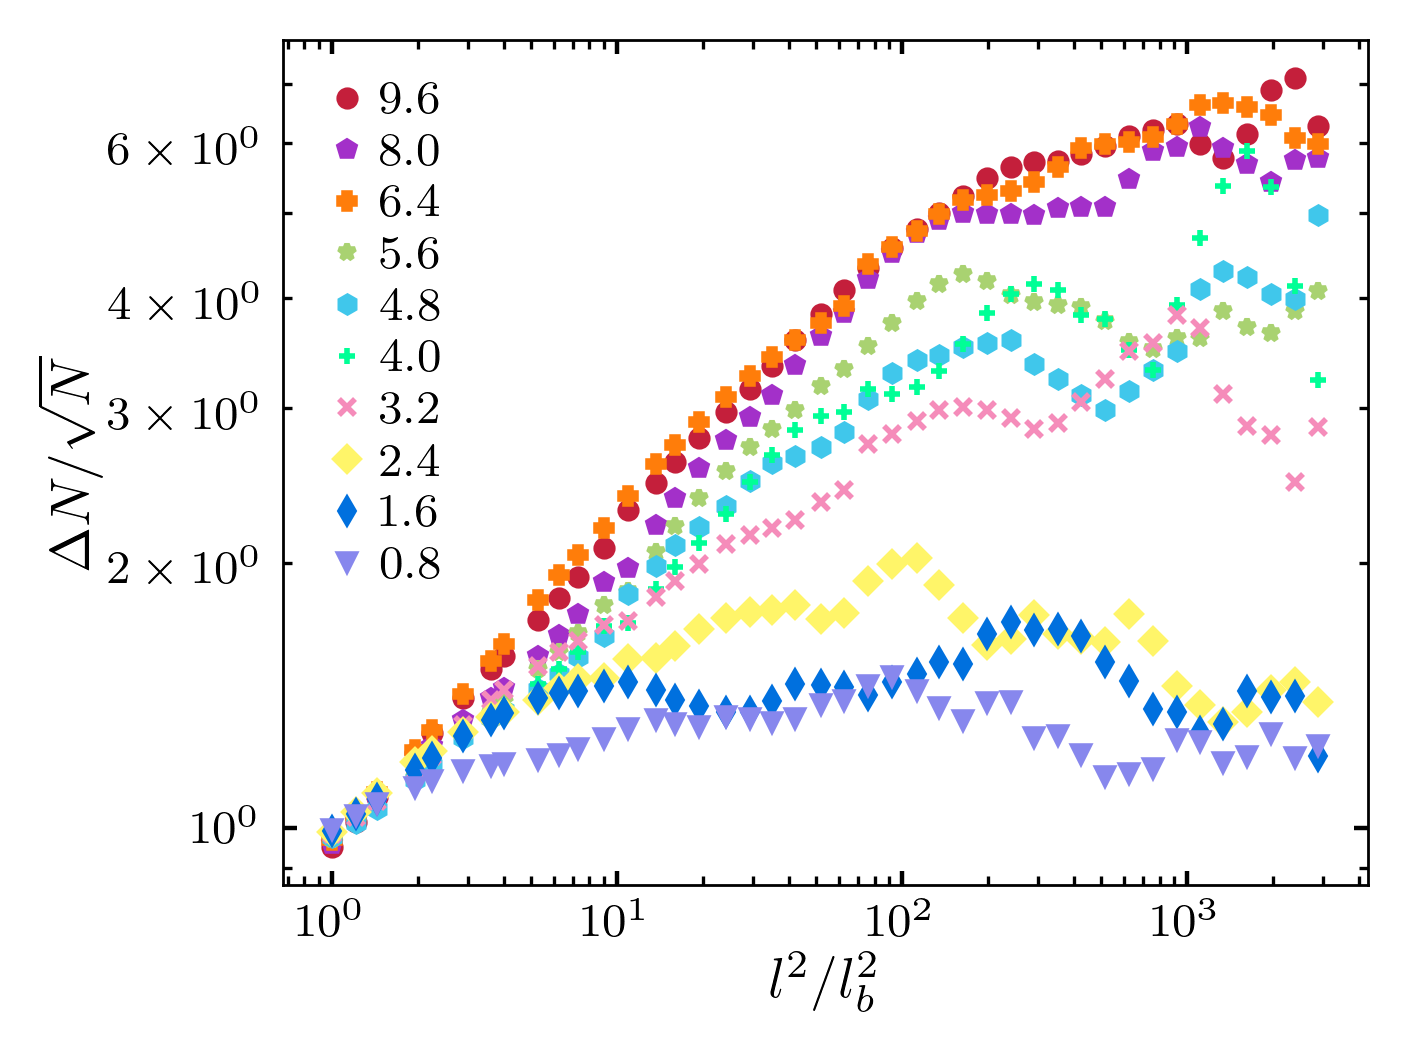

In [49]:
conc, folders, sample_num = tentative_log()
master_file = os.path.join(data_master_dir, r'Research projects\DF\data\transient-nGNF-energy\{0}\df2_kinetics\{1:02d}\nGNF_data.csv')
fig, ax = plt.subplots(figsize=(3.5, 2.8))
for c, f, s in zip(conc, folders, sample_num):
    if c != 85:
        file = master_file.format(f, s[1])
        data = pd.read_csv(file).set_index('l_r')
        ax.plot(data.index, data[data.keys()[-1]], color=wowcolor(color_dict[str(c)]), marker=marker_list[color_dict[str(c)]],
               markersize=3, ls='', label='{:.1f}'.format(c*0.08))
ax.legend()
ax.set_xlabel('$l^2/l_b^2$')
ax.set_ylabel('$\Delta N/\sqrt N$')
ax.set_yticks([1, 2, 3, 4, 6])
ax.set_yticklabels(['1', '2', '3', '4', '6'])
ax.loglog()
# ax.ticklabel_format(useOffset=False, axis='y')